In [1]:
import numpy as np
from utils import *
import emoji
import matplotlib.pyplot as plt
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [3]:
maxLen = len(max(X_train, key=len).split())

In [4]:
index = 1
print(X_train[index], label_to_emoji(Y_train[index]))

I am proud of your achievements 😄


In [5]:
def sentences_to_indices(X, word_to_index, max_len):

    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros((m,max_len))    
    for i in range(m):                               # loop over training examples
        
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            
            X_indices[i, j] = word_to_index[w]
            j += 1
    
    return X_indices

In [6]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    
    embedding_layer = Embedding(vocab_len, emb_dim,trainable=False)

    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [7]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [8]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)   
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation("softmax")(X)
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [9]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [12]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 16, shuffle=True)

Epoch 1/50
9/9 [==============================] - 4s 15ms/step - loss: 1.5966 - accuracy: 0.2494
Epoch 2/50
9/9 [==============================] - 0s 13ms/step - loss: 1.4872 - accuracy: 0.3292
Epoch 3/50
9/9 [==============================] - 0s 14ms/step - loss: 1.3855 - accuracy: 0.4389
Epoch 4/50
9/9 [==============================] - 0s 15ms/step - loss: 1.2190 - accuracy: 0.5853
Epoch 5/50
9/9 [==============================] - 0s 15ms/step - loss: 0.9626 - accuracy: 0.6512
Epoch 6/50
9/9 [==============================] - 0s 17ms/step - loss: 0.7781 - accuracy: 0.7037
Epoch 7/50
9/9 [==============================] - 0s 17ms/step - loss: 0.6457 - accuracy: 0.7679
Epoch 8/50
9/9 [==============================] - 0s 17ms/step - loss: 0.7128 - accuracy: 0.7267
Epoch 9/50
9/9 [==============================] - 0s 17ms/step - loss: 0.4353 - accuracy: 0.8644
Epoch 10/50
9/9 [==============================] - 0s 19ms/step - loss: 0.3345 - accuracy: 0.8866
Epoch 11/50
9/9 [============

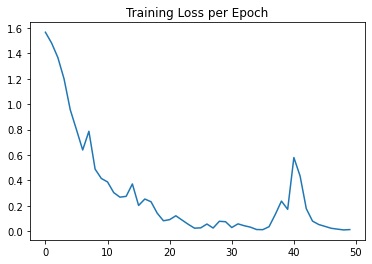

In [13]:
import seaborn as sns
loss = model.history.history['loss']
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch");

In [14]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 1s 8ms/step - loss: 0.2828 - accuracy: 0.8929

Test accuracy =  0.8928571343421936


In [15]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
